In [1]:
import os
os.chdir("../../")

import torch
import matplotlib.pyplot as plt

from models.bs_class import Bs
from torch.distributions import Uniform

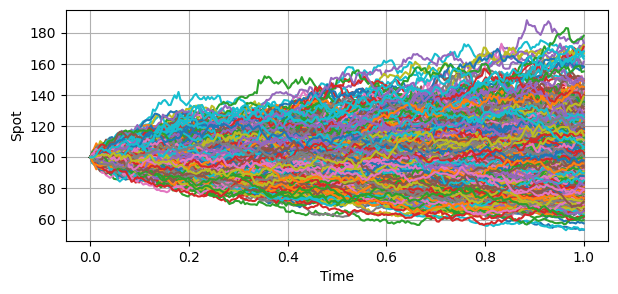

In [2]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
T = 1.0
S0 = torch.tensor(100.0)

mu_true = torch.tensor(0.01)
sigma_true = torch.tensor(0.2)

bs_model = Bs(mu_true, sigma_true)
S = bs_model.simulate(S0, dt, T, M=1000)

plt.figure(figsize=(7,3))
plt.plot(torch.linspace(0, T, len(S)), S.detach())
plt.xlabel('Time')
plt.ylabel('Spot')
plt.grid()
plt.show()

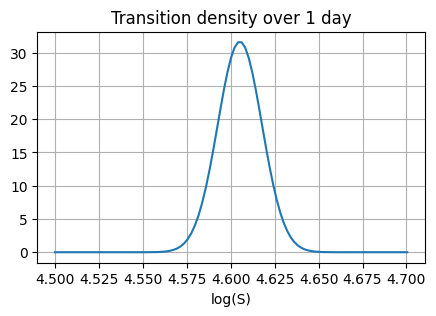

In [4]:
plt.figure(figsize=(5, 3))

S_next = torch.linspace(S0 - 10, S0 + 10, 100)
transition = bs_model.transition(S0, S_next, dt)
plt.plot(torch.log(S_next), transition.detach())
plt.grid()
plt.xlabel('log(S)')
plt.title(f'Transition density over {int(dt * 252)} day')
plt.show()

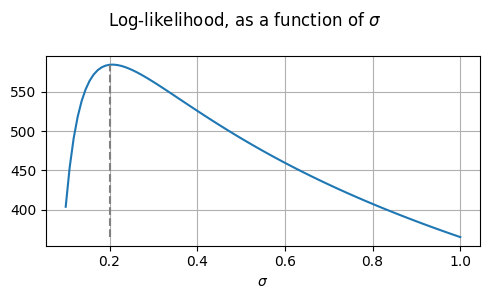

In [4]:
t = 252 
window = 200
n_params = 1
fig = plt.figure(figsize=(5, 3))
spot_prices = S[:, 0]

sigmas = torch.linspace(0.1, 1.0, 100)
likelihood = torch.zeros_like(sigmas)
for i, sigma in enumerate(sigmas):
    model = Bs(mu_true, sigma)
    likelihood[i] = model.forward(spot_prices, t, dt, window)
plt.plot(sigmas, likelihood.detach(), label='log-likelihood')
plt.vlines(sigma_true, torch.min(likelihood.detach()), torch.max(likelihood.detach()), linestyles='dashed', colors='grey', label='true')
plt.xlabel(r'$\sigma$')
plt.grid()

fig.suptitle(rf'Log-likelihood, as a function of $\sigma$')
fig.tight_layout()

In [ ]:
torch.manual_seed(42)
t = S.shape[0] - 1
window = 200

n_paths = S.shape[1]
n_params = 1
stats = {
    "mle": torch.zeros(size=(n_paths, n_params)),
    "max_value": torch.zeros(size=(n_paths,)),
    "n_it": torch.zeros(size=(n_paths,)),
    "no_convergence": 0,
}

max_it = 1000
grad_norm_threshold = 1e-3
for i in range(n_paths):
    mu = mu_true
    sigma = Uniform(low=0.01, high=1.5).sample()
    #print("Init: ", sigma.item())

    model = Bs(mu_true, sigma)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.1, maximize=True)
    spot_prices = S[:, i]
    for j in range(max_it):
        optimizer.zero_grad()
        loss = model.forward(spot_prices, t=t, delta_t=dt, window=window)
        loss.backward()
        total_norm = torch.norm(torch.cat([p.grad.view(-1) for p in model.parameters() if p.grad is not None]))
    
        #print(f"Epoch {j}, Loss: {loss.item():.3f}, Grad Norm: {total_norm.item():.3f}")
        if total_norm < grad_norm_threshold:
            stats["n_it"][i] = j
            break
        if j == max_it - 1:
            stats["n_it"][i] = j
            stats["no_convergence"] += 1
            print("Maximum iteration reached.")
        optimizer.step()

    params = model.get_params()
    stats["mle"][i, 0] = params[0]

    model = Bs(mu_true, params[0])
    value = model.forward(spot_prices, t=t, delta_t=dt, window=window)
    stats["max_value"][i] = value

In [31]:
mean = torch.mean(stats["mle"], dim=0)
std = torch.std(stats["mle"], dim=0)
avg_it = torch.mean(stats["n_it"])
avg_distance_to_argmax = torch.mean(torch.abs(stats["mle"][:, 0] - sigma_true))
n_no_conv = stats["no_convergence"]

true_max_value = Bs(mu_true, sigma_true).forward(spot_prices, t=t, delta_t=dt, window=window).item()
avg_distance_to_max = torch.mean(torch.abs(stats["max_value"] - true_max_value)).item()

print(f"Average MLE: {mean.item():.3f}")
print(f"Std MLE {std.item():.3f}")
print(f"Average distance to true parameter: {avg_distance_to_argmax.item():.3f}")
print(f"Average relative error to the true maximum: {((true_max_value - avg_distance_to_max) / true_max_value):.3f}")
print(f"Average number of iteration to convergence {avg_it.item():.3f}")
print(f"Number of parameters where GD didn't converge: {n_no_conv}")

Average MLE: 0.200
Std MLE 0.010
Average distance to true parameter: 0.008
Average relative error to the true maximum: 0.974
Average number of iteration to convergence 182.491
Number of parameters where GD didn't converge: 0
